In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/bitmusic38/bin/python


In [2]:
import numpy as np
from collections import Counter

import torch
from torch import nn

from music21 import stream, note, instrument

import json

import os

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import hiddenlayer as hl

In [3]:
"""

    where am i?
    
"""

PATH = os.getcwd() + '/'
data_path = PATH + 'data/'
train_path = data_path + '/nesmdb_midi/train/'
output_path = data_path + 'output/'
corpus_path = output_path + 'corpus/'
model_path = PATH + 'model/'

print(f'PATH: {PATH}')
print(f'data path: {data_path}')
print(f'train path: {train_path}')
print(f'output path: {output_path}')
print(f'corpus path: {corpus_path}')
print(f'model path: {model_path}')
print('\n')

PATH: /Users/no_lineal/Documents/GitHub/mir_project/
data path: /Users/no_lineal/Documents/GitHub/mir_project/data/
train path: /Users/no_lineal/Documents/GitHub/mir_project/data//nesmdb_midi/train/
output path: /Users/no_lineal/Documents/GitHub/mir_project/data/output/
corpus path: /Users/no_lineal/Documents/GitHub/mir_project/data/output/corpus/
model path: /Users/no_lineal/Documents/GitHub/mir_project/model/




In [4]:
"""

    device

"""

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'device: {device}')

device: cpu


corpus raw size: 157339932
unique chars: 2415


corpus cut size: 144574
unique chars: 447




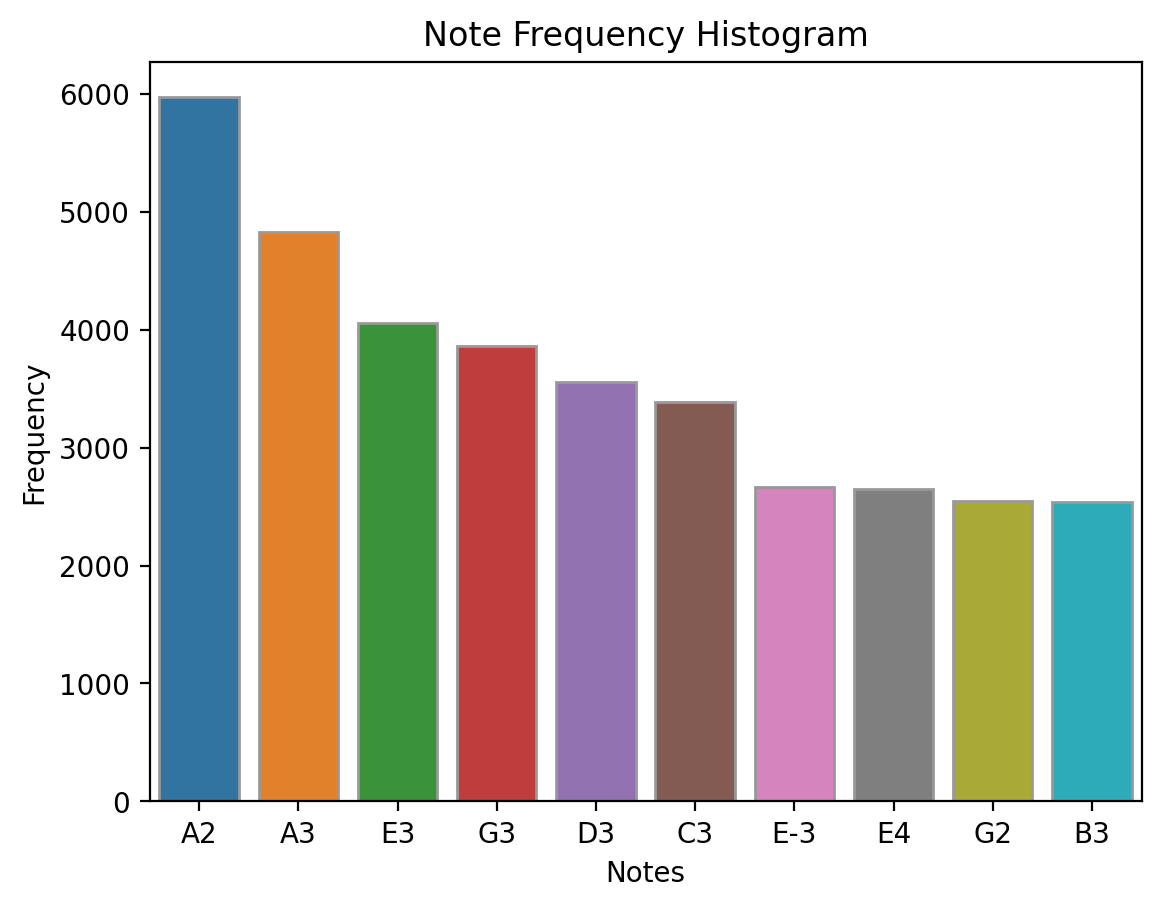

In [5]:
"""

    load corpus

"""

corpus = json.load( open( output_path + 'corpus.json', 'r' ) )

print(f'corpus raw size: {len(corpus)}')
print(f'unique chars: {len(set(corpus))}')
print('\n')

corpus = corpus[:144574]
n_vocab = len(set(corpus))

print(f'corpus cut size: {len(corpus)}')
print(f'unique chars: { n_vocab }')
print('\n')

# Count the frequency of words
word_counts = Counter(corpus)
top_words = word_counts.most_common(10)  # Specify the number of top words you want to plot
words, counts = zip(*top_words)

# Plot the histogram
sns.barplot(x=list(words), y=list(counts), edgecolor=".6")
plt.xlabel('Notes')
#plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Note Frequency Histogram')
plt.show()

min loss: 2008.8740525953472


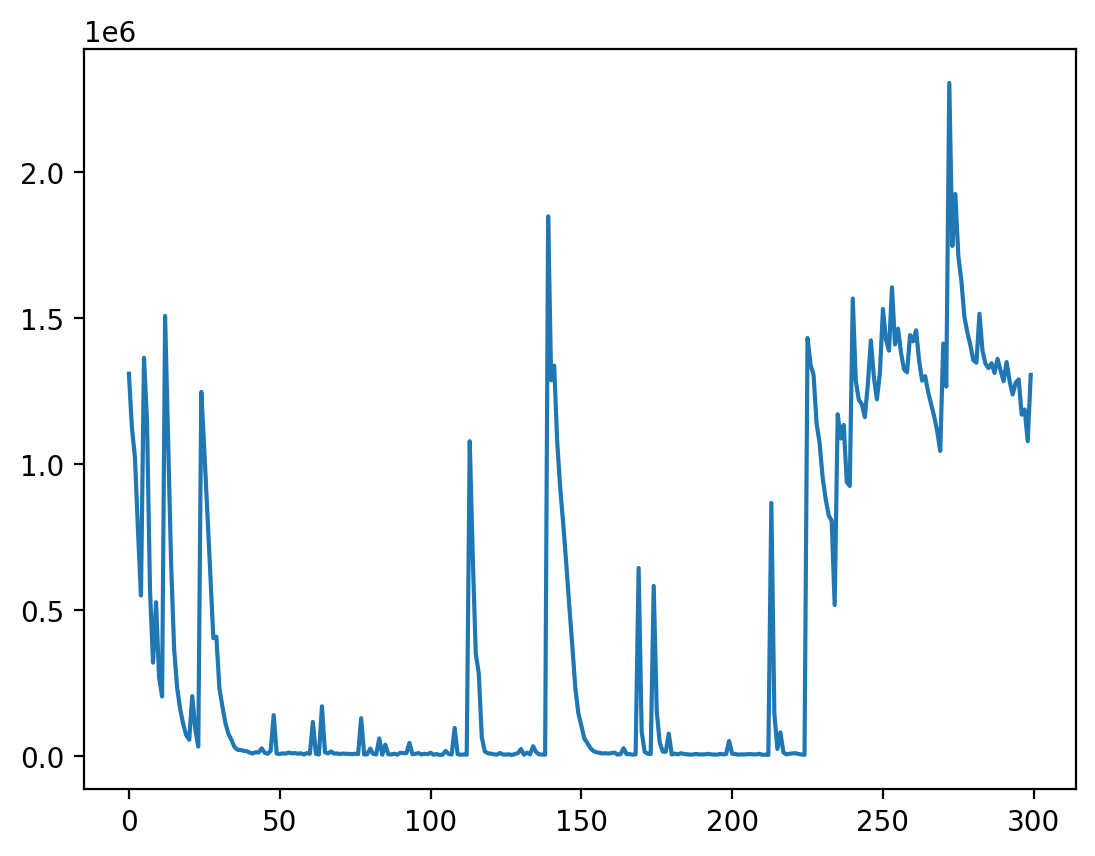

In [11]:
""" 

    load loss

"""

with open(output_path + 'bitLSTM_loss.json', 'r') as f:
    loss = json.load(f)

x = range(len(loss))
y = list( loss.values() )

print(f'min loss: {min(y)}')

sns.lineplot(x=x, y=y)
plt.show()

In [7]:
""" 

    load model and mapping

"""

best_model, mapping = torch.load( model_path + 'bitLSTM.pt', map_location=torch.device('cpu') )

In [8]:
""" 

    lstm

"""

class bitLSTM( nn.Module ):

    def __init__(self):

        super().__init__()

        self.lstm = nn.LSTM( input_size=1, hidden_size=512, num_layers=1, batch_first=True )
        self.dropout = nn.Dropout( p=0.2 )
        self.fc = nn.Linear( in_features=512, out_features=n_vocab )

    def forward(self, x):

        x, _ = self.lstm( x )
        x = x[ : , -1 , : ]
        x = self.dropout( x )
        x = self.fc( x )

        return x
    
model = bitLSTM().to(device)
model.load_state_dict( best_model )

print(f'model: {model}')

model: bitLSTM(
  (lstm): LSTM(1, 512, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=447, bias=True)
)


In [85]:
""" 

    generator

"""

#corpus = json.load( open( output_path + 'corpus.json', 'r' ) )

#print(f'corpus raw size: {len(corpus)}')
#print(f'unique chars: {len(set(corpus))}')
#print('\n')

seq_length = 100
start = np.random.randint(0, len(corpus) - seq_length)
start = np.random.choice( [90509, 18899, 51646, 62086, 46475, 74925] )
prompt = corpus[ start : start + seq_length ]
pattern = [ mapping[c] for c in prompt ]

print(f'idx start:\n {start}')
print(f'prompt:\n {prompt}')
print(f'pattern:\n {pattern}')

reverse_mapping = dict((i, c) for c, i in mapping.items())

model.eval()

with torch.no_grad():

    for i in range(100):

        x = np.reshape( pattern, ( 1, len(pattern), 1 ) ) / float( n_vocab )
        x = torch.tensor( x, dtype=torch.float32 )

        predict = model( x )

        idx = int( predict.argmax() )
        result = reverse_mapping[idx]

        pattern.append( idx )
        pattern = pattern[1:]

print(f'generated pattern:\n {pattern}')
pattern = [ reverse_mapping[c] for c in pattern ]
print(f'generated pattern:\n {pattern}')

idx start:
 46475
prompt:
 ['8', '4.8', '7.8', '7.8.9.10.11.0', '7', '3.7', '7', '10.3', '7', '7.10', '7', '3', '7', '6.7.10', '7', '3.7.8', '9.10.11.0', '7', '7.11', '7.9', '0.2.4', '9', '5.11', '9.0', '9.11', '10.11.0.1.2.3.4', '11', '7.11', '11.3', '2.3.4', '5.6.7.8', '3', '0.3', '3', '7.0', '3', '3.7', '2.3', '0.2.3', '4.5.6.7', '2', '10.2', '0.2', '7.10.0.1', '2.3.4.5', '0', '7.0', '0', '3.7', '0', '0.3', '7.0', '6.7.8', '8.9.10.11.0', '7', '7.10', '3.7', '2.3.4', '5.6.7.8', '3', '0.3', '3', '0.4.8', '3', '7.8', '0.3', '3', '8.0', '3', '0.3', '2.3', '2', '2.3.4.5.6.7', '10.2', '1.2', '7.10', '1', '0.1.6', '1.2', '10.2.3', '2.3.4.5.6.7', '2', '11.2', '2.8', '7.8.9', '10.11.0.1', '8', '10.1', '8', '5.11', '5.8', '8', '10.1', '8', '8', '5.8', '8.1', '7.8', '7.8.10', '9.10.11.0']
pattern:
 [300, 203, 274, 282, 263, 171, 263, 89, 263, 266, 263, 153, 263, 249, 263, 174, 345, 263, 271, 291, 17, 329, 211, 330, 358, 74, 90, 271, 115, 123, 217, 153, 23, 153, 264, 153, 171, 122, 16, 186, 121

In [86]:
""" 

    melody

"""

melody_midi = stream.Stream()

for note_str in pattern:

    try:
        n = note.Note(note_str)
        melody_midi.append(n)
    except:
        n = str(note_str)
        n = n.split('.')
        for n_ in n:
            n = note.Note()
            n.pitch.midi = int(n_)
            melody_midi.append(n)

melody_midi.insert(0, instrument.Piano())
midi_file = melody_midi.write("midi", fp=output_path + "output.mid")
